# Introduction to Using TensorRT with SuperGradients' YoloNAS Model in Google Colab

![Super Gradients](https://github.com/Deci-AI/super-gradients/raw/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow%202.png)

Welcome to this tutorial where we will harness the efficiency and speed of TensorRT, a high-performance deep learning inference optimizer.

Our focus will be on the [SuperGradients](https://www.supergradients.com/) library, an open-source training platform designed for PyTorch-based deep learning models. SuperGradients simplifies the training and fine-tuning process for state-of-the-art (SOTA) pre-trained models, catering to a range of computer vision tasks such as object detection, image classification, and semantic segmentation.

As a small teaser what you will be able to achive by the end of this tutorial we want to show you this plot with measured throughput of the same model using different inference approaches:

<img src="https://raw.githubusercontent.com/Deci-AI/super-gradients/12e741146b9ad3a7cb36682bc4c487b141706968/documentation/source/images/yolo_nas_inference_comparison_pytorch_vs_tensorrt.png" width=600 alt="YoloNAS Inference Performance Comparison" />

The tutorial is structured to guide you through the following key steps:

**Exporting a YoloNAS Model to ONNX Format**: We will start by taking a [YoloNAS](https://github.com/Deci-AI/super-gradients/blob/master/YOLONAS.md) model from SuperGradients and exporting it to the ONNX (Open Neural Network Exchange) format. ONNX is an open format designed to represent machine learning models, offering interoperability across various AI frameworks.

**Converting ONNX Model to TensorRT Engine**: Once our model is in ONNX format, we will convert it into a TensorRT engine. TensorRT is an SDK for high-performance deep learning inference, providing optimized inference for NVIDIA GPUs. It enhances the performance of deep learning models by optimizing network computations and reducing memory footprint.

**Running Inference Using TensorRT**: With our model now optimized for performance, we will run inference using the TensorRT engine. This process involves using the model to make predictions or decisions based on new input data.

**Visualizing Predictions**: Finally, we will explore how to visualize the predictions made by our TensorRT-optimized model, bringing to life the object detection capabilities of YoloNAS in a tangible and insightful manner.

By the end of this tutorial, you will have gained hands-on experience in optimizing deep learning models for inference using TensorRT, and visualizing the output of an advanced object detection model. Let's dive in and unlock the potential of efficient and high-performance AI models.

## Installing dependencies

To begin our journey into optimizing YoloNAS models with TensorRT, the first step is to set up our working environment. This setup is crucial as it ensures that all necessary libraries and dependencies are correctly installed and configured. The code snippet below is designed to prepare your Google Colab environment for the tasks ahead.


In [1]:
import locale
# This hack is to prevent occasional issue in Colab https://github.com/googlecolab/colabtools/issues/3409
locale.getpreferredencoding = lambda *args: "UTF-8"

!pip install -qq super-gradients==3.6.0
!pip install -qq tensorrt~=8.6 pycuda pytorch-quantization==2.1.2 --extra-index-url https://pypi.ngc.nvidia.com

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 47.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 24.4 MB/s eta 0:00

Before we proceed with the model optimization, it's essential to verify that our Google Colab environment is correctly configured with CUDA and all the necessary packages are installed. This check ensures that we can utilize GPU acceleration for efficient model processing. The following code snippet accomplishes this:

**If the cell below ends up with any sort of error please double check you are using GPU-enabled Colab instance.**

In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

print(trt.__version__)

trt_logger = trt.Logger(trt.Logger.VERBOSE)

device = cuda.Device(0)
device.compute_capability()

8.6.1


(7, 5)

## Exporting YoloNAS to TensorRT

Before we dive into the hands-on demonstration, it's important to clarify the scope and purpose of this tutorial. The forthcoming sections, filled with step-by-step code examples, are designed primarily for educational and demonstrative purposes. We aim to provide a clear and comprehensive guide on how to export a YoloNAS model to ONNX format and subsequently leverage TensorRT for running inference.

**Key Points to Note:**
**Demonstrative Code**: The code snippets included in this tutorial are intended to illustrate the fundamental steps required to transform a YoloNAS model into a TensorRT-optimized engine. This will include exporting the model, converting it, and running inference tasks.

**Sub-Optimal Performance**: It's crucial to understand that while the provided examples will give you a practical insight into the process, they may not be fine-tuned for maximum performance efficiency. The focus here is on the procedural aspect rather than achieving the highest possible inference speed or accuracy.

**Exploring Advanced Solutions for Maximum Efficiency:**

**Deci's [Infery](https://deci.ai/blog/infery/) Platform**: Another avenue for achieving exceptional inference performance is through the Deci Infery platform. Deci specializes in optimizing deep learning models, offering tools that can automatically enhance model efficiency while maintaining, or even improving, their accuracy. Infery allow a unified API (TRT, OpenVINO, TFLite, CoreML, etc.) and Advanced Techniques such as Selective Quantization, Asynchronous Inference Pipeline, and Multi-Model inference

**NVIDIA Triton Inference Server**: For those seeking to deploy models in NVidia GPU environments, NVIDIA Triton Inference Server is a highly recommended solution. Triton provides a cloud and edge inferencing solution that optimizes GPU resources, supports multiple models and frameworks, and scales according to computational needs.




### Exporting a YoloNAS Model to ONNX Format

To efficiently utilize the YoloNAS model for inference, we first export it to ONNX format, optimized for TensorRT. We begin by importing the necessary modules from the SuperGradients library, including model handling and conversion classes. Next, we initialize the YoloNAS model with COCO dataset pre-trained weights, ensuring readiness for object detection. Finally, the model is exported as an ONNX file, with preprocessing and postprocessing included, specifically optimized for TensorRT usage.

To learn more about supported features of model export please refer to our [documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/models_export.md) page.

In [3]:
import super_gradients
from super_gradients.common.object_names import Models
from super_gradients.training import models
from super_gradients.conversion.conversion_enums import ExportTargetBackend, ExportQuantizationMode, DetectionOutputFormatMode

yolonas = models.get(Models.YOLO_NAS_M, pretrained_weights="coco")
yolonas.export("yolonas_m.onnx", preprocessing=True, postprocessing=True, engine=ExportTargetBackend.TENSORRT)

[2024-01-17 14:30:45] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-01-17 14:31:03] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command
I0117 14:31:03.676037 137661543486080 env_sanity_check.py:87] Library check is not supported when super_gradients installed through "git+https://github.com/..." command
Downloading: "https://sghub.deci.ai/models/yolo_nas_m_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_m_coco.pth
100%|██████████| 196M/196M [00:13<00:00, 15.4MB/s]
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

Collecting onnx_graphsurgeon==0.3.27

Downloading https://developer.download.nvidia.com/compute/redist/onnx-graphsurgeon/onnx_graphsurgeon-0.3.27-py2.py3-none-any.whl (42 kB)

Output()

Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from onnx_graphsurgeon==0.3.27) (1.23.0)

Requirement already satisfied: onnx in /usr/local/lib/python3.10/dist-packages (from onnx_graphsurgeon==0.3.27) (1.13.0)

Requirement already satisfied: protobuf<4,>=3.20.2 in /usr/local/lib/python3.10/dist-packages (from onnx->onnx_graphsurgeon==0.3.27) (3.20.3)

Requirement already satisfied: typing-extensions>=3.6.2.1 in /usr/local/lib/python3.10/dist-packages (from onnx->onnx_graphsurgeon==0.3.27) (4.5.0)

Installing collected packages: onnx_graphsurgeon

Successfully installed onnx_graphsurgeon-0.3.27

Created NMS plugin 'EfficientNMS_TRT' with attributes: {'plugin_version': '1', 'background_class': -1, 'max_output_boxes': 1000, 'score_threshold': 0.25, 'iou_threshold': 0.7, 'score_activation': False, 'box_coding': 0}

Model exported successfully to yolonas_m.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.7
    confidence_threshold=0.25
    output_predictions_format=batch

Exported model is in ONNX format and can be used with TensorRT
To run inference with TensorRT, please see TensorRT deployment documentation
You can benchmark the model using the following code snippet:

    trtexec --onnx=yolonas_m.onnx --fp16 --avgRuns=100 --duration=15

Exported model has predictions in batch format:

    num_detections, pred_boxes, pred_scores, pred

### Converting ONNX Model to TensorRT Engine

In this section, we'll focus on converting the exported ONNX file of the YoloNAS model into a TensorRT engine, a process vital for enhancing inference performance. The function convert_onnx_to_trt_engine takes the path of the ONNX file and the desired output file name for the TensorRT engine. It initializes TensorRT's builder and network with explicit batch processing, crucial for handling dynamic input sizes. The function also configures the builder with detailed profiling and FP16 optimization for improved performance. Upon successful parsing of the ONNX file, it serializes the optimized TensorRT network into a file, thus completing the conversion process.

This conversion is a critical step in optimizing the model for efficient inference on NVIDIA GPUs, making it ready for high-performance object detection tasks.

Execution time of this cell is somewhat significant. **It may take up to ten  minutes to finish the execution**. During this time TensorRT performs model optimization of the specific GPU model and selects the most efficient computational kernels to use at model inference.

In [4]:
from typing import List, Tuple
import tensorrt as trt


def convert_onnx_to_trt_engine(onnx_file, trt_output_file, enable_int8_quantization:bool = False):
  EXPLICIT_BATCH = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

  with trt.Builder(trt_logger) as builder, builder.create_network(EXPLICIT_BATCH) as network, builder.create_builder_config() as config:

    config = builder.create_builder_config()
    config.profiling_verbosity = trt.ProfilingVerbosity.DETAILED

    if enable_int8_quantization:
      config.set_flag(trt.BuilderFlag.INT8)
    else:
      config.set_flag(trt.BuilderFlag.FP16)

    config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 30)

    # Load your ONNX model
    with trt.OnnxParser(network, trt_logger) as onnx_parser:
      with open(onnx_file, 'rb') as f:
        parse_success = onnx_parser.parse(f.read())
        if not parse_success:
          errors = "\n".join(
              [str(onnx_parser.get_error(error)) for error in range(onnx_parser.num_errors)]
          )
          raise RuntimeError(f"Failed to parse onnx model for trt conversion. Errors: \n{errors}")

      trt_logger.log(trt.ILogger.INFO, "Parsed ONNX model")

    # Query input names and shapes from parsed TensorRT network
    network_inputs = [network.get_input(i) for i in range(network.num_inputs)]
    input_names = [_input.name for _input in network_inputs]  # ex: ["actual_input1"]

    assert input_names[0] == 'input'

    serialized_engine = builder.build_serialized_network(network, config)
    with open(trt_output_file, "wb") as output_file:
      output_file.write(serialized_engine)
      trt_logger.log(trt.ILogger.INFO, "Serialization done")

convert_onnx_to_trt_engine("yolonas_m.onnx", "yolonas_m.trt")

Working with TensorRT involves interacting with a relatively low-level API, which requires the user to handle several key aspects of memory management. This is crucial for efficient GPU utilization and accurate model inference. The code snippet here addresses these requirements:

`HostDeviceMem` Class: This class facilitates the management of memory by keeping track of both host and device memory allocations. This is essential for synchronizing data between the CPU (host) and GPU (device).

**Buffer Allocation**: The `allocate_buffers` function plays a critical role in allocating memory buffers for inputs and outputs of the model. It handles the creation of both host and device buffers, ensuring that the data is correctly formatted and stored for the TensorRT engine.

**Engine Loading**: The `load_engine` function is responsible for loading the serialized TensorRT engine from a file. It ensures the engine is properly deserialized and ready for performing inference tasks.

**Engine Initialization**: Finally, the engine is loaded using load_engine, preparing it for executing inference with the allocated buffers.

These steps collectively prepare the environment for running inference with TensorRT.

In [5]:
import os


class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()


def allocate_buffers(engine):
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()
    for binding in engine:
        size = trt.volume(engine.get_binding_shape(binding)[1:]) * engine.max_batch_size
        dtype = trt.nptype(engine.get_binding_dtype(binding))
        binding_index = engine.get_binding_index(binding)

        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        # Only bytes, no need for size
        device_mem = cuda.mem_alloc(host_mem.nbytes)

        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))

        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings, stream

def load_engine(engine_file_path):
  assert os.path.exists(engine_file_path)
  print("Reading engine from file {}".format(engine_file_path))
  with open(engine_file_path, "rb") as f, trt.Runtime(trt_logger) as runtime:
    serialized_engine = f.read()
    engine = runtime.deserialize_cuda_engine(serialized_engine)
    return engine


## Running Inference Using TensorRT


In the next code snippet, we need to write boilerplate code for inference using the TensorRT engine with a specific focus on object detection. There are several key aspects to note:

**Fixed Inference Shape**: The inference shape is hard-coded to 640x640 pixels, as this is the specific shape for which the TensorRT engine was compiled. Regardless of the input image shape we resize it to 640x640 without preserving aspect ratio. We do this for sake of simplicity.  

**Batch Size**: We use a hard-coded batch size of 1, indicating that inference is run on one image at a time. This simplifies the process and is typical for many object detection tasks.

**Batched Format for Detection Prediction**s: The output from the inference process comes in a "batched format," which includes a tuple with four elements:

* num_detections `[B]`: The number of detections per each image in batch.
* detected_boxes `[B, MaxDetections, 4]`: The coordinates of the detected boxes in XYXY format.
* detected_scores `[B, MaxDetections]`: The confidence scores for each detection.
* detected_labels `[B, MaxDetections]`: The labels for each detected object.

**Preprocessing and Postprocessing**: The `preprocess` function prepares the image for inference, resizing it to the required dimensions and rearranging its channels. The `postprocess` function then adjusts the detected boxes' coordinates back to the scale of the original image, ensuring that the predictions correspond correctly to the input image's dimensions.

This code segment encapsulates the entire workflow of preparing an image for inference, running the inference, and processing the output, thus enabling accurate object detection using a TensorRT-optimized model.

In [6]:
import cv2
import numpy as np


class InferenceSession:
  def __init__(self, engine_file, inference_shape: Tuple[int,int]):
    self.engine = load_engine(engine_file)
    self.context = None
    self.inference_shape = inference_shape

  def __enter__(self):
      self.context = self.engine.create_execution_context()
      assert self.context

      self.context.set_input_shape('input', (1, 3, *self.inference_shape))
      self.inputs, self.outputs, self.bindings, self.stream = allocate_buffers(self.engine)

      return self

  def preprocess(self, image):
      image = np.array(image)
      rows, cols = self.inference_shape
      original_shape = image.shape[:2]
      # Resize image to fixed size
      image = cv2.resize(np.array(image), dsize=(cols, rows))
      # Switch from HWC to to CHW order
      return np.moveaxis(image, 2, 0), original_shape

  def postprocess(self, detected_boxes, original_shape: Tuple[int, int]):
      sx = original_shape[1] / self.inference_shape[1]
      sy = original_shape[0] / self.inference_shape[0]
      detected_boxes[:, :, [0, 2]] *= sx
      detected_boxes[:, :, [1, 3]] *= sy
      return detected_boxes

  def __call__(self, image):
      batch_size = 1
      input_image, original_shape = self.preprocess(image)

      self.inputs[0].host[:np.prod(input_image.shape)] = np.asarray(input_image).ravel()

      [cuda.memcpy_htod(inp.device, inp.host) for inp in self.inputs]
      success = self.context.execute_v2(bindings=self.bindings)
      assert success
      [cuda.memcpy_dtoh(out.host, out.device) for out in self.outputs]

      num_detections, detected_boxes, detected_scores, detected_labels = [o.host for o in self.outputs]

      num_detections = num_detections.reshape(-1)
      num_predictions_per_image = len(detected_scores) // batch_size
      detected_boxes  = detected_boxes.reshape(batch_size, num_predictions_per_image, 4)
      detected_scores = detected_scores.reshape(batch_size, num_predictions_per_image)
      detected_labels = detected_labels.reshape(batch_size, num_predictions_per_image)

      detected_boxes = self.postprocess(detected_boxes, original_shape) # Scale coordinates back to original image shape
      return num_detections, detected_boxes, detected_scores, detected_labels


  def __exit__(self, exc_type, exc_val, exc_tb):
    del self.inputs, self.outputs, self.bindings, self.stream, self.context


In [7]:
from super_gradients.training.utils.detection_utils import DetectionVisualization
from super_gradients.training.datasets.datasets_conf import COCO_DETECTION_CLASSES_LIST
from super_gradients.training.utils.media.image import load_pil_image_from_str

image = load_pil_image_from_str("https://deci-datasets-research.s3.amazonaws.com/image_samples/beatles-abbeyroad.jpg")

with InferenceSession("yolonas_m.trt", (640, 640)) as session:
  result = session(image)

# Show first 10 boxes
result[1][0, :10]

Reading engine from file yolonas_m.trt


array([[675.575   , 313.80762 , 880.6875  , 678.85547 ],
       [279.45624 , 309.7705  , 458.64374 , 657.7383  ],
       [ 55.948437, 308.0625  , 268.20938 , 673.2656  ],
       [166.9875  , 294.70898 , 309.0031  , 410.85352 ],
       [461.69376 , 326.6953  , 672.14374 , 670.16016 ],
       [379.1531  , 278.8711  , 424.33124 , 318.6211  ],
       [733.90625 , 273.5918  , 756.39996 , 350.60742 ],
       [590.5562  , 286.32422 , 624.8687  , 335.70117 ],
       [570.73126 , 279.3369  , 611.90625 , 313.18652 ],
       [462.07498 , 265.82812 , 483.04373 , 285.2373  ]], dtype=float32)

## Visualizing Predictions

In this section, we focus on visualizing the predictions obtained from the TensorRT-inferred object detection model.

`show_predictions_from_batch_format` is a function that visualizes the predictions on the original image. It retrieves the predictions for the first image in the batch and combines the detected boxes, scores, and classes into a single array.

This combined data is then used to visualize the detections on the image using `DetectionVisualization.visualize_image`, which overlays the predicted boxes and class labels onto the image.

Finally, the function displays the annotated image using matplotlib, providing a clear and intuitive visualization of the model's detections.

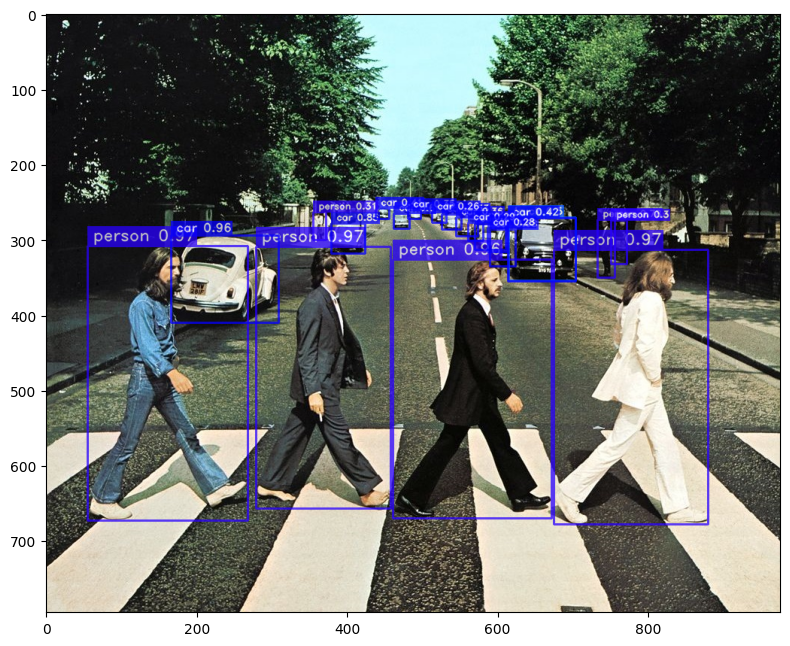

In [13]:
import matplotlib.pyplot as plt
from super_gradients.inference import iterate_over_detection_predictions_in_batched_format


def show_predictions_from_batch_format(image, predictions):
    image_index, pred_boxes, pred_scores, pred_classes = next(iter(iterate_over_detection_predictions_in_batched_format(predictions)))

    predicted_boxes = np.concatenate([pred_boxes, pred_scores[:, np.newaxis], pred_classes[:, np.newaxis]], axis=1)

    image = DetectionVisualization.visualize_image(
        image_np=np.array(image),
        class_names=COCO_DETECTION_CLASSES_LIST,
        pred_boxes=predicted_boxes
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()

show_predictions_from_batch_format(image, result)

Let's compare the results of prediction using the same model but with PyTorch inference.


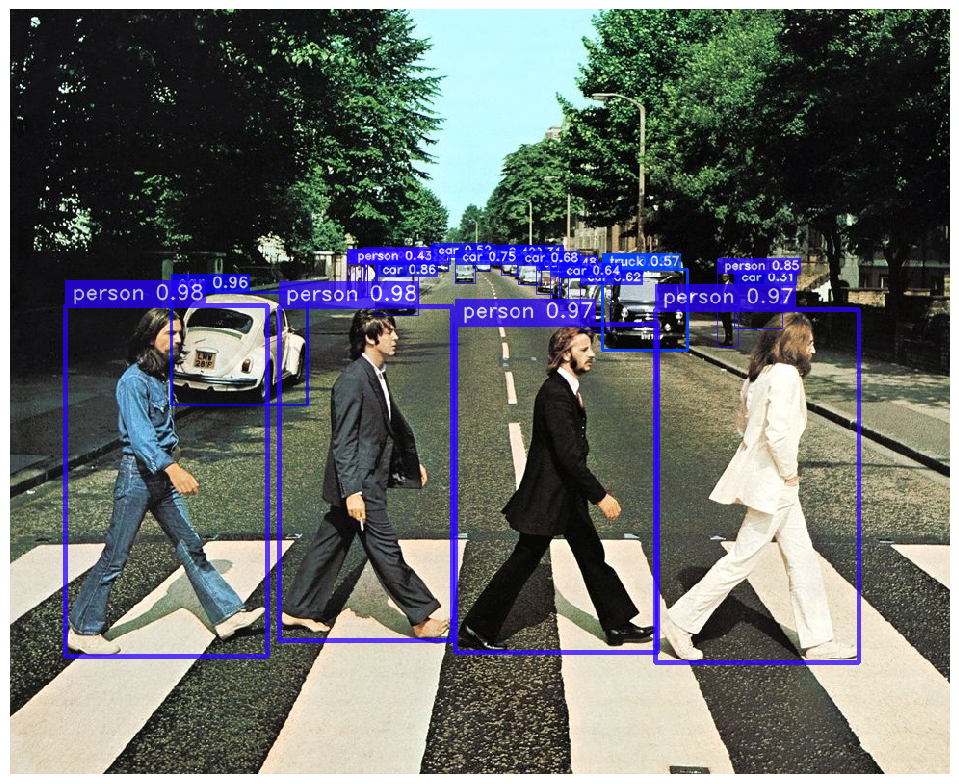

In [14]:
yolonas.predict(image, fuse_model=False).show()

When evaluating the object detection results using the YoloNAS model, it's important to understand that there may be subtle differences between predictions made with PyTorch and those made using TensorRT.

This divergence, often seen in the positioning of bounding boxes and the confidence scores, is primarily due to the distinct computational kernels employed by each framework. While PyTorch utilizes its native kernels for inference, TensorRT optimizes the model further, which can lead to variations in how computations are performed.

Such discrepancies are normal and expected, reflecting the unique characteristics and optimizations inherent to each inference engine.

## Quantization Support

YoloNAS supports export of INT8 quantized model to ONNX and inference using TensorRT. It does not require too much effort from your side to export INT8 model. Just two changes is needed to the existing code:

**Enable INT8 quantization during export to ONNX**. This is done by adding `quantization_mode=ExportQuantizationMode.INT8` argument to our `export()` call.

**Enable INT8 flag during build of TensorRT Engine**. For this purpose we have `enable_int8_quantization=True` argument set for `convert_onnx_to_trt_engine` call.

And that's it! This is the minimal set of actions to export the model with INT8 quantization. A calibration step is not covered in this tutorial for the sake of keeping the notebook of reasonable size. We encourage you reading separate tutorial on [Quantization Aware Training YoloNAS on Custom Dataset](https://colab.research.google.com/github/Deci-AI/super-gradients/blob/master/notebooks/yolo_nas_custom_dataset_fine_tuning_with_qat.ipynb) which explains advanced topics.


In [15]:
from super_gradients.conversion.conversion_enums import ExportQuantizationMode

yolonas = models.get(Models.YOLO_NAS_M, pretrained_weights="coco")
yolonas.export("yolonas_m_int8.onnx", preprocessing=True, postprocessing=True, engine=ExportTargetBackend.TENSORRT, quantization_mode=ExportQuantizationMode.INT8)
convert_onnx_to_trt_engine("yolonas_m_int8.onnx", "yolonas_m_int8.trt", enable_int8_quantization=True)

License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.

Successfully loaded pretrained weights for architecture yolo_nas_m

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConvTranspose2d with axis None!

Weight is fake quantized to 8 bits in QuantConvTranspose2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConvTranspose2d with axis None!

Weight is fake quantized to 8 bits in QuantConvTranspose2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

Input is fake quantized to 8 bits in QuantConv2d with axis None!

Weight is fake quantized to 8 bits in QuantConv2d with axis 0!

Creating histogram calibrator

Creating Max calibrator

WARNING: Use Pytorch's native experimental fake quantization.


/usr/local/lib/python3.10/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if amax.numel() == 1:
/usr/local/lib/python3.10/dist-packages/pytorch_quantization/nn/modules/tensor_quantizer.py:286: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  inputs, amax.item() / bound, 0,
/usr/local/lib/python3.10/dist-packages/pytorch_quantization/utils/reduce_amax.py:61: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python

Created NMS plugin 'EfficientNMS_TRT' with attributes: {'plugin_version': '1', 'background_class': -1, 'max_output_boxes': 1000, 'score_threshold': 0.25, 'iou_threshold': 0.7, 'score_activation': False, 'box_coding': 0}

Reading engine from file yolonas_m_int8.trt


<ipython-input-5-56244ad65111>:22: DeprecationWarning: Use get_tensor_shape instead.
  size = trt.volume(engine.get_binding_shape(binding)[1:]) * engine.max_batch_size
<ipython-input-5-56244ad65111>:22: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  size = trt.volume(engine.get_binding_shape(binding)[1:]) * engine.max_batch_size
<ipython-input-5-56244ad65111>:23: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(engine.get_binding_dtype(binding))
<ipython-input-5-56244ad65111>:24: DeprecationWarning: Use get_tensor_name instead.
  binding_index = engine.get_binding_index(binding)
<ipython-input-5-56244ad65111>:35: DeprecationWarning: Use get_tensor_mode instead.
  if engine.binding_is_input(binding):


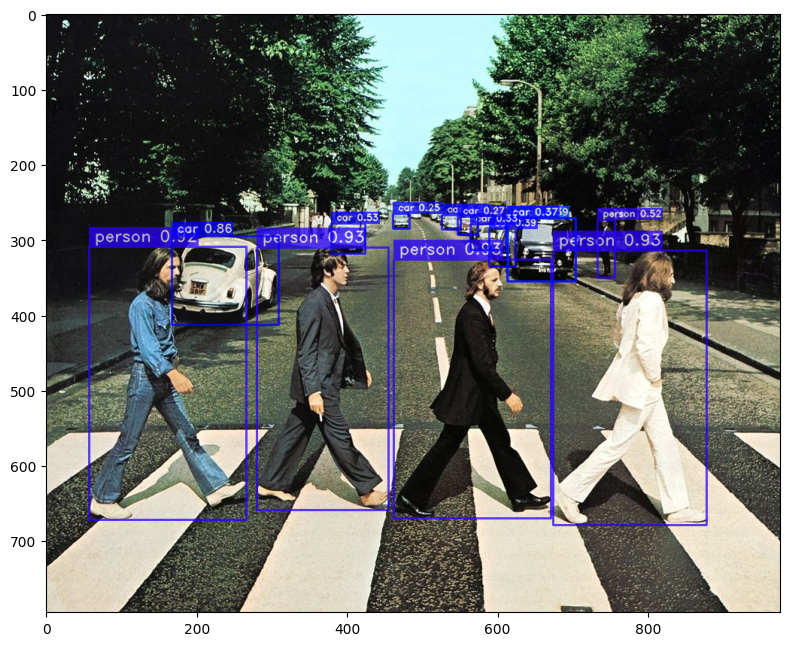

In [16]:
with InferenceSession("yolonas_m_int8.trt", (640, 640)) as session:
  result_int8 = session(image)

show_predictions_from_batch_format(image, result_int8)

# Measuring Inference Speed

In this section, we aim to measure and compare the inference speeds of the YoloNAS model using different engines. We will conduct a series of inferences (1000 iterations each) using the PyTorch engine, TensorRT with FP16 optimization, and TensorRT with INT8 quantization. This will be done by timing these inferences and calculating the throughput, giving us a clear picture of the performance differences across these inference methods.

In [20]:
import cv2
num_iterations = 1000

yolonas_pipeline = yolonas.cuda()._get_pipeline(fuse_model=False)

# Run inference using PyTorch engine
start = cv2.getTickCount()
for _ in range(num_iterations):
  yolonas_pipeline(image)
finish = cv2.getTickCount()
pytorch_throughput = cv2.getTickFrequency() * num_iterations / (finish - start)


# Run inference using TensorRT engine
start = cv2.getTickCount()
with InferenceSession("yolonas_m.trt", (640, 640)) as session:
  for _ in range(num_iterations):
    session(image)
finish = cv2.getTickCount()
trt_fp16_throughput = cv2.getTickFrequency() * num_iterations / (finish - start)


# Run inference using TensorRT engine and INT8 quantized model
start = cv2.getTickCount()
with InferenceSession("yolonas_m_int8.trt", (640, 640)) as session:
  for _ in range(num_iterations):
    session(image)
finish = cv2.getTickCount()
trt_int8_throughput = cv2.getTickFrequency() * num_iterations / (finish - start)


pytorch_throughput, trt_fp16_throughput, trt_int8_throughput

Reading engine from file yolonas_m.trt


<ipython-input-5-56244ad65111>:22: DeprecationWarning: Use get_tensor_shape instead.
  size = trt.volume(engine.get_binding_shape(binding)[1:]) * engine.max_batch_size
<ipython-input-5-56244ad65111>:22: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  size = trt.volume(engine.get_binding_shape(binding)[1:]) * engine.max_batch_size
<ipython-input-5-56244ad65111>:23: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(engine.get_binding_dtype(binding))
<ipython-input-5-56244ad65111>:24: DeprecationWarning: Use get_tensor_name instead.
  binding_index = engine.get_binding_index(binding)
<ipython-input-5-56244ad65111>:35: DeprecationWarning: Use get_tensor_mode instead.
  if engine.binding_is_input(binding):


Reading engine from file yolonas_m_int8.trt


(14.468735572673497, 96.67966487507015, 109.13102727564322)

Following the inference speed measurements, we will now visualize the results to better understand the performance differences. This visualization is done using a bar chart that compares Frames Per Second (FPS) across the PyTorch engine, TensorRT with FP16, and TensorRT with INT8 quantization. By presenting the data in this manner, we can easily interpret and compare the efficiency of each inference method.

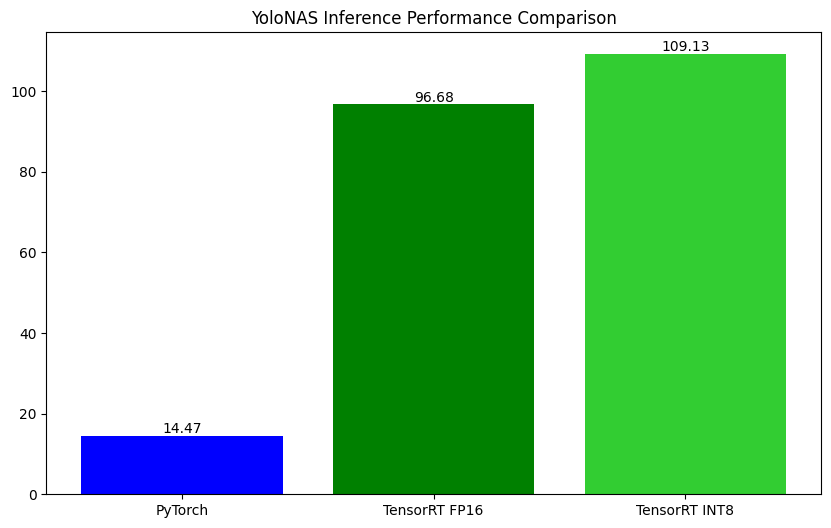

In [21]:
import matplotlib.pyplot as plt

# Bar names and their corresponding inference latencies in milliseconds
bar_names = ["PyTorch", "TensorRT FP16", "TensorRT INT8"]
latencies_ms = [67.16, 9.88, 9.54]  # Inference latencies in ms

# Calculating Frames Per Second (FPS) from latencies
fps_values = [pytorch_throughput, trt_fp16_throughput, trt_int8_throughput]

# Colors for each bar
colors = ['blue', 'green', 'limegreen']

# Creating the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(bar_names, fps_values, color=colors)

# Adding the FPS values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Removing the grid
plt.grid(False)

# Adding title
plt.title("YoloNAS Inference Performance Comparison")

# Show the plot
plt.show()

# Conclusion

In this tutorial, we've embarked on a comprehensive journey through the process of exporting, converting, and running a YoloNAS model for object detection, utilizing both TensorRT and PyTorch frameworks. Here's a recap of our key takeaways:

**TensorRT for Enhanced Performance**: We demonstrated how to export a YoloNAS model to ONNX format and convert it into a TensorRT engine. We gained almost **10x** speedup compared to naive PyTorch inference.

**Understanding Memory Management**: The tutorial showed the aspects of memory management and device/host data transfers when working with TensorRT.

**Visualizing Predictions**: We learned how to visualize the outputs of our TensorRT-optimized model, showing how these models interpret and understand real-world images.

**Comparing TensorRT and PyTorch Inferences**: We also discussed the subtle differences in prediction results when using TensorRT compared to PyTorch. These differences are expected due to the distinct computational approaches of each framework, showcasing the diversity in machine learning tools.

# Additional Resources

* [YoloNAS Quickstart Documentation](https://github.com/Deci-AI/super-gradients/blob/master/YOLONAS.md)
* [YoloNAS Export to ONNX Documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/models_export.md)
* [TensorRT Documentation](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html)
* [Quantization Aware Training YoloNAS on Custom Dataset](https://colab.research.google.com/github/Deci-AI/super-gradients/blob/master/notebooks/yolo_nas_custom_dataset_fine_tuning_with_qat.ipynb)
